# **Wine Quality Prediction**

##Setup: imports and useful functions



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import where
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.random import randint
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import copy #for deep copying
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!mkdir dataset
!wget -P dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv  
!wget -P dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv  

--2021-03-08 12:36:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘dataset/winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.1s    

2021-03-08 12:36:47 (775 KB/s) - ‘dataset/winequality-red.csv’ saved [84199/84199]

--2021-03-08 12:36:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘dataset/winequality-white.csv’

winequa

#### Functions for analysing dataset

In [3]:
def print_correlation_matrix(correlation, title):
  fig, ax = plt.subplots(1,1,figsize=(15,10))
  correlation.style.background_gradient(cmap='Blues').set_precision(2)
  sns.heatmap(correlation, cmap='Blues', ax=ax, annot=True, fmt='.1g')
  ax.set_title(title, fontsize=18, y=1.05)

#### Data preprocessing functions

In [4]:
def bootstrap(X, bootstrap_size=400):
  # create bootstrap of X of given size
  current_samples = len(X)
  indexes_b = randint(0, current_samples, bootstrap_size)
  X_bootstraps = X.iloc[indexes_b].copy()
  return X_bootstraps

def estimate_mean_stdev_with_bootstrap(X, n_bootstraps, bootstrap_size=400):
  # create n_bootstraps sets from X and use it to calculate more precise stats
  X_bootstrap_sets = [bootstrap(X, bootstrap_size) for _ in range(n_bootstraps)]
  means = [X_set.mean() for X_set in X_bootstrap_sets]
  stdevs = [X_set.std() for X_set in X_bootstrap_sets]

  est_mean = pd.DataFrame(means).mean()
  est_stdev = pd.DataFrame(stdevs).mean()

  err_mean = (pd.DataFrame([(est_mean-x)**2 for x in means]).sum()/(len(X_bootstrap_sets)-1))**0.5
  err_stds = (pd.DataFrame([(est_stdev-x)**2 for x in stdevs]).sum()/(len(X_bootstrap_sets)-1))**0.5

  return est_mean, est_stdev, err_mean, err_stds

#### Plots functions

In [5]:
def plot_histograms(df, columns, title, color, figsize=(12,5), legend=True):
  plt.style.use('ggplot')
  df.hist(column=columns, figsize=figsize, rwidth=0.5, color=color)
  plt.title(title, fontsize=18, y=1.05)
  plt.xlabel(columns[0])
  plt.ylabel('Number of students')
  plt.xticks(np.arange(21), np.arange(21))
  plt.show()

def print_histograms(data, subtitles=None, title='insert_title', figsize=(10,5)):
  plt.style.use('ggplot')
  shape = data.shape
  n_isto =  shape[1]
  fig, ax = plt.subplots(1, n_isto, figsize=figsize, sharey=False)
  maxy = []
  #for i in range(n_isto):
  x = data[:,0]
  possible_qualities = np.arange(11) # possible quality from 0 to 11
  values = [len(x[x == i]) for i in possible_qualities] # count the number of wines per quality
  values, _, _ = ax.hist(x, np.arange(12), density=False, rwidth=0.8)
  if subtitles is not None:
    ax.set_title(subtitles, fontsize=14)
  plt.sca(ax)
  ax.set_xlim((-0.5,11.5))
  ax.set_xlabel('Quality')
  ax.set_ylabel('Number of Wines')
  plt.xticks(np.arange(11)+.5, np.arange(11))
  maxy.append(max(values))
  fig.suptitle(title, fontsize=24, y=0.98)
  fig.subplots_adjust(top=0.85)
  maxy = max(maxy)
  #for i in range(n_isto):
  ax.set_ylim((0,maxy+100))

def plot_df_means(X1_mean, X2_mean, label1, label2, title, figsize=(10,5)):
  plt.figure(figsize=figsize)
  plt.bar(X1_mean.index, X1_mean, color='red', label=label1)
  plt.bar(X2_mean.index, X2_mean, color='blue', label=label2)
  plt.xticks(rotation='vertical')
  plt.title(title, fontsize=18)
  plt.legend()
  plt.show()

def plot_explained_variance(explained_variance, title):
  plt.style.use('ggplot')
  plt.figure(figsize=(7,7))
  plt.plot(np.cumsum(explained_variance))
  plt.title(title)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variance')
  # plot vertical line for  y=variance=90%
  line = plt.gca().get_lines()[0]
  x = line.get_xdata()
  y = line.get_ydata().round(2)
  index_90th = np.where(y >= 0.91)
  x_90th = x[index_90th[0][0]]
  plt.axvline(x=x_90th, marker='.', ls='--', color='blue', label='90% variance or grater')
  plt.legend()
  plt.show()
  return x_90th

def make_meshgrid(X0, X1, h):
    """
    Create a mesh of points to be plotted
    :param X0: data to base x-axis meshgrid on
    :param X1:  data to base y-axis meshgrid on
    :param h: stepsize for meshgrid
    :return: nd arrays
    """
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_decision_boundaries(ax, clf, xx, yy, n_features, **params):
    """
    Plot decision boundaries of the given classifier
    :param ax: axes of the matplotlib object
    :param clf: classifier
    :param xx: nd array
    :param yy: nd array
    :param params: parameters to pass to countours
    :return: contours
    """
    Xpred = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(n_features-2)]).T
    Z = clf.predict(Xpred)
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, **params)
    return contours

def decision_boundaries(X_test, y_test, str, clf):
  figure, axes = plt.subplots(1, 1)
  print(X_test)
  print("n_features: ",len(X_test.columns))
  X0, X1 = X_test['PC0'], X_test['PC1']
  xx, yy = make_meshgrid(X0, X1, 0.2)
  plot_decision_boundaries(axes, clf, xx, yy, n_features=len(X_test.columns), cmap=plt.cm.coolwarm, alpha=0.8)
  axes.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
  axes.set_xlim(xx.min(), xx.max())
  axes.set_ylim(yy.min(), yy.max())
  axes.set_xlabel('PC1')
  axes.set_ylabel('PC2')
  axes.set_title(str) 

## Dataset Analysis

In [6]:
data_wine_red = pd.read_csv('dataset/winequality-red.csv', ';')
data_wine_white = pd.read_csv('dataset/winequality-white.csv', ';')

In [7]:
data_wine_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [8]:
data_wine_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [9]:
print("Number of features in Math dataset: ", len(data_wine_red.columns))
print("Number of features in Portuguese dataset: ", len(data_wine_white.columns))

Number of features in Math dataset:  12
Number of features in Portuguese dataset:  12


In [10]:
# Check missing values
null_math = data_wine_red.isna().sum().sum()
null_port = data_wine_white.isna().sum().sum()
print("Missing values in Math dataset: ", null_math)
print("Missing values in Portuguese dataset: ", null_port)

Missing values in Math dataset:  0
Missing values in Portuguese dataset:  0


### Features Distribution

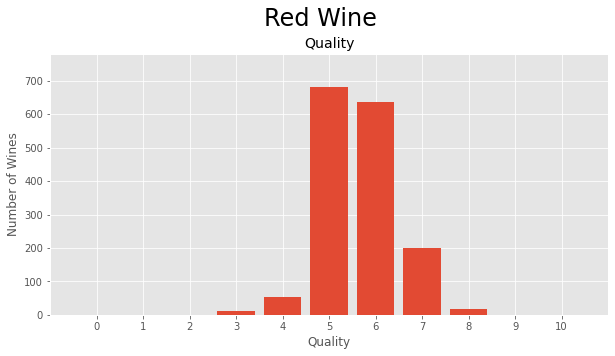

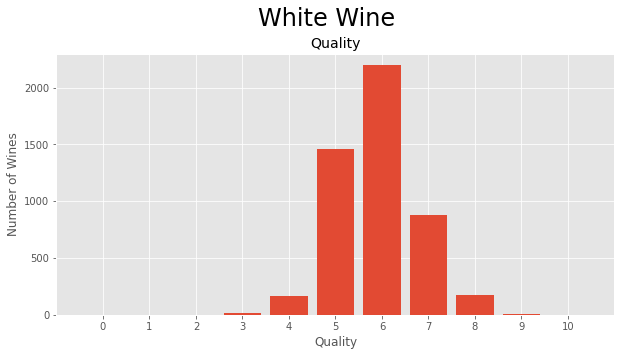

In [11]:
#quality distribution 
print_histograms(data_wine_red[['quality']].to_numpy(), title='Red Wine', subtitles='Quality')
print_histograms(data_wine_white[['quality']].to_numpy(), title='White Wine', subtitles='Quality')

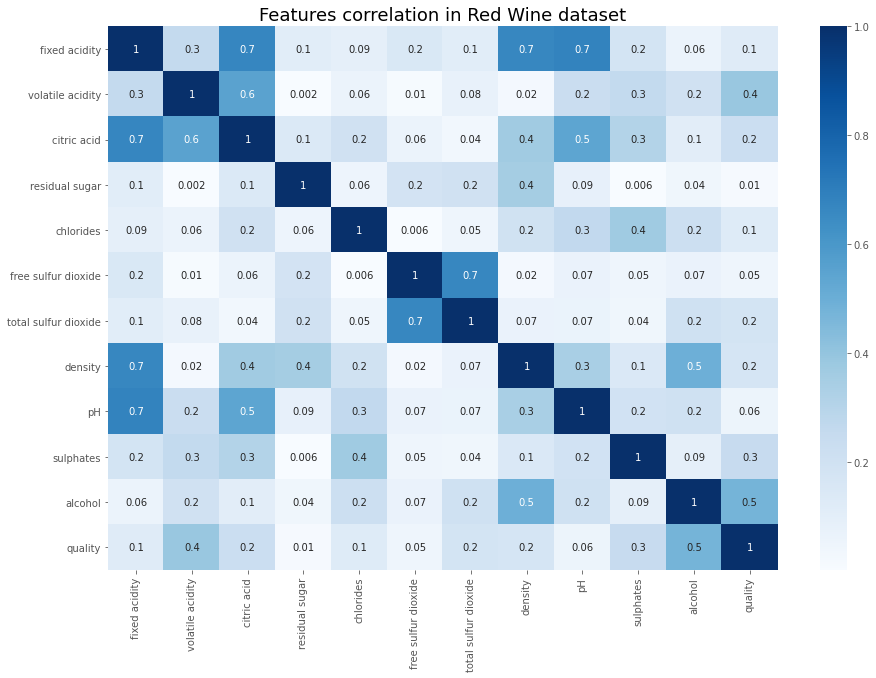

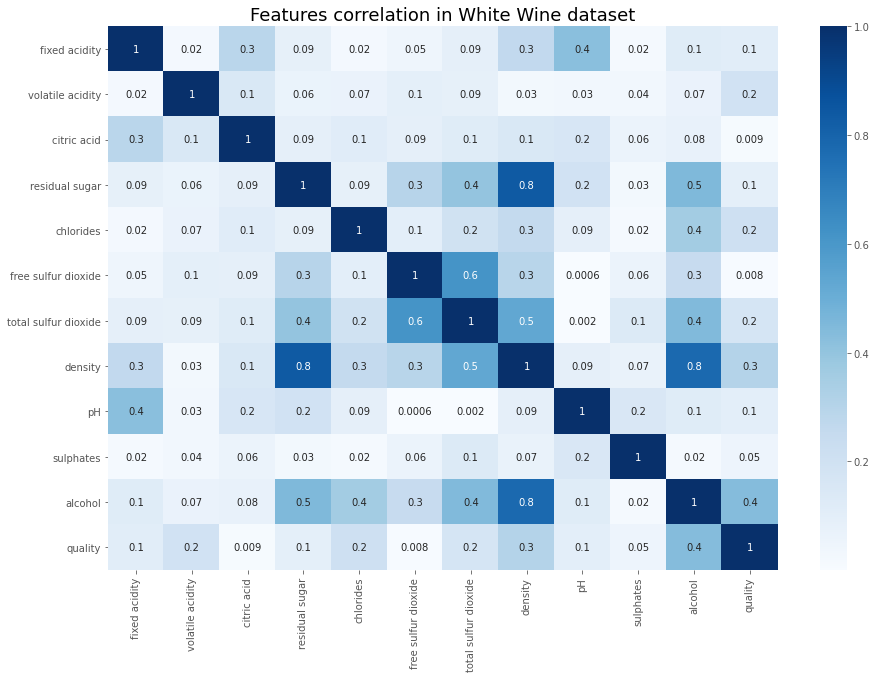

In [12]:
# Features correlation
print_correlation_matrix(data_wine_red.corr().abs(), 'Features correlation in Red Wine dataset')
print_correlation_matrix(data_wine_white.corr().abs(), 'Features correlation in White Wine dataset')

In [13]:
# Drop low correlated features to target ('quality')
threshold = 0.07
to_drop_red_wine = data_wine_red.corr().abs()['quality'] < threshold
to_drop_white_wine = data_wine_white.corr().abs()['quality'] < threshold
to_drop_red_wine = list((to_drop_red_wine[to_drop_red_wine]).index.values)
to_drop_white_wine = list((to_drop_white_wine[to_drop_white_wine]).index.values)
print("Candidate features to be dropped in Red Wine dataset: ", to_drop_red_wine)
print("Candidate features to be dropped in White Wine dataset: ", to_drop_white_wine)

Candidate features to be dropped in Red Wine dataset:  ['residual sugar', 'free sulfur dioxide', 'pH']
Candidate features to be dropped in White Wine dataset:  ['citric acid', 'free sulfur dioxide', 'sulphates']


In [14]:
data_wine_red = data_wine_red.drop(columns=to_drop_red_wine)
data_wine_white = data_wine_white.drop(columns=to_drop_white_wine)
print("Number of features in Red Wine dataset: ", len(data_wine_red.columns))
print("Number of features in White Wine dataset: ", len(data_wine_white.columns))

Number of features in Red Wine dataset:  9
Number of features in White Wine dataset:  9


## Data preprocessing and statistics

### Datasets statistics

#### Red Wine dataset statistics

Good:  53.47 %
Bad:  46.53 %
Counter({True: 855, False: 744})


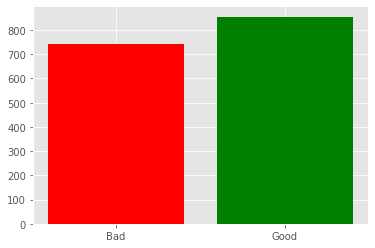

In [15]:
good_r = pd.value_counts(data_wine_red['quality'].values > 5 )[1]
print('Good: ', round(good_r/len(data_wine_red)*100, 2),'%')

bad_r = pd.value_counts( data_wine_red['quality'].values <= 5 )[1]
print('Bad: ', round(bad_r/len(data_wine_red)*100, 2),'%')

counter = Counter(data_wine_red['quality'].values > 5)
print(counter)

x = np.array(['Bad','Good'])
y = np.array([bad_r,good_r])
plt.bar(x, y, color=['red','green'])
plt.show()

#### White Wine dataset statistics

Good:  66.52 %
Bad:  33.48 %
Counter({True: 3258, False: 1640})


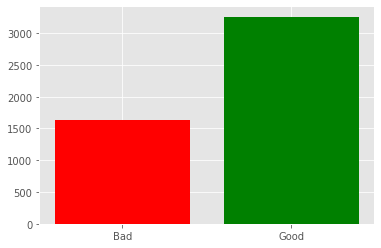

In [16]:
good_w = pd.value_counts(data_wine_white['quality'].values > 5 )[1]
print('Good: ', round(good_w/len(data_wine_white)*100, 2),'%')

bad_w = pd.value_counts( data_wine_white['quality'].values <= 5 )[1]
print('Bad: ', round(bad_w/len(data_wine_white)*100, 2),'%')

counter = Counter(data_wine_white['quality'].values > 5)
print(counter)

x = np.array(['Bad','Good'])
y = np.array([bad_w,good_w])
plt.bar(x, y, color=['red','green'])
plt.show()

#### Boxplot

In [17]:
def print_boxplots(X, Y, atributes=['Red wines', 'White wines'], y_val='quality', figsize=(15,5), title = 'Insert Title'):
  
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  fig.suptitle(title, fontsize=24, y=0.98)
  fig.subplots_adjust(top=0.85)
  
  sns.boxplot(y=y_val, data=X, ax=ax[0], showmeans=True, medianprops={'color':'yellow'})    
  ax[0].set_xlabel(atributes[0].capitalize()) 

  sns.boxplot(y=y_val, data=Y, ax=ax[1], showmeans=True, medianprops={'color':'yellow'})    
  ax[1].set_xlabel(atributes[1].capitalize())

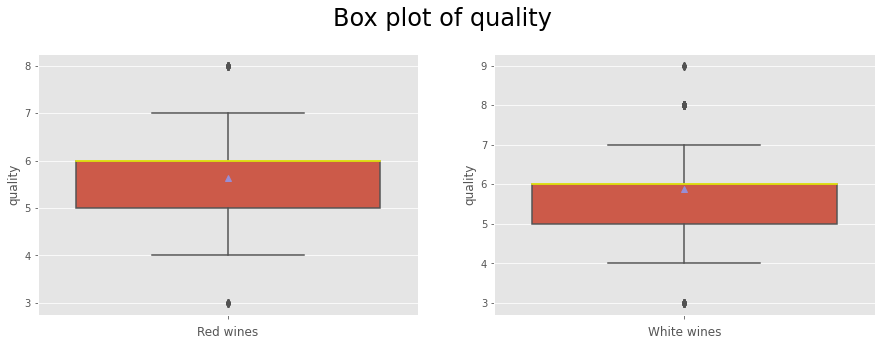

In [18]:
print_boxplots(data_wine_red, data_wine_white, title = 'Box plot of quality')

In [19]:
quality_red = data_wine_red['quality'].to_numpy()
quality_white = data_wine_white['quality'].to_numpy()

counter_r = Counter(data_wine_red['quality'].values)
counter_w = Counter(data_wine_white['quality'].values)

In [20]:
# creo l'insieme degli indici dei dati che sono considerati outliers. Questi set mi serviranno successivamente per la regressione
quality_r_3 = set(data_wine_red[data_wine_red['quality']==3].index) # red wines with wuality = 3
quality_r_8 = set(data_wine_red[data_wine_red['quality']==8].index) # red wines with wuality = 8
quality_r_out = quality_r_3.union(quality_r_8)

quality_w_3 = set(data_wine_white[data_wine_white['quality']==3].index) # white wines with wuality = 3
quality_w_8 = set(data_wine_white[data_wine_white['quality']==8].index) # white wines with wuality = 8
quality_w_9 = set(data_wine_white[data_wine_white['quality']==9].index) # white wines with wuality = 9
quality_w_out = quality_w_3.union(quality_w_8).union(quality_w_9)

### Train and Test set creation

In [21]:
# Create X and y
#print(data_wine_red.shape)
X_red_wine = data_wine_red[data_wine_red.columns.difference(['quality'])]
#print(X_red_wine.shape)
y_red_wine = data_wine_red['quality']

X_white_wine = data_wine_white[data_wine_white.columns.difference(['quality'])]
y_white_wine = data_wine_white['quality']

In [22]:
# Create train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_red_wine, y_red_wine, test_size=0.2, stratify=y_red_wine, random_state=42) # 'stratify=y' allows to create a test split with an equal percentage
# of positive and negative labels
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_white_wine, y_white_wine, test_size=0.2, stratify=y_white_wine, random_state=42)

### Bootstrap and Feature Scaling


In [23]:
est_mean_train_r, est_dev_train_r, sem_train_r, err_std_train_r = estimate_mean_stdev_with_bootstrap(X_train_r, n_bootstraps=100)
est_mean_test_r, est_dev_test_r, sem_test_r, err_std_test_r = estimate_mean_stdev_with_bootstrap(X_test_r, n_bootstraps=100)

est_mean_train_w, est_dev_train_w, sem_train_w, err_std_train_w = estimate_mean_stdev_with_bootstrap(X_train_w, n_bootstraps=100, bootstrap_size=700)
est_mean_test_w, est_dev_test_w, sem_test_w, err_std_test_w = estimate_mean_stdev_with_bootstrap(X_test_w, n_bootstraps=100, bootstrap_size=700)

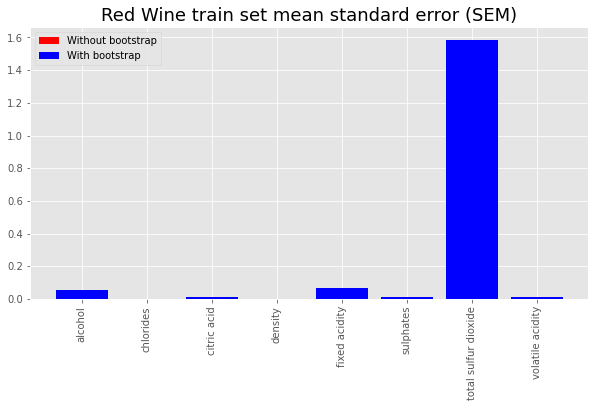

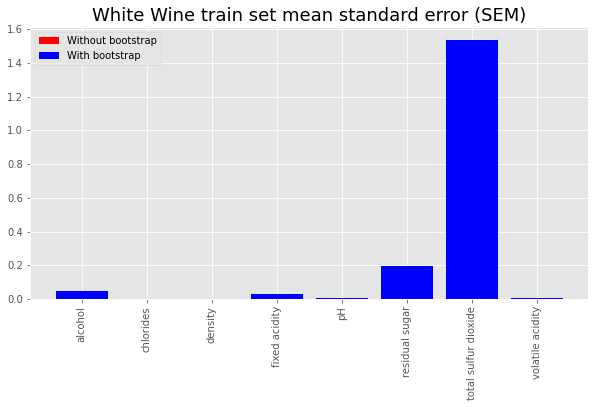

In [24]:
# SEM: measures how far the sample mean of the data is likely to be from the true population mean
plot_df_means(X_train_r.sem(), sem_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set mean standard error (SEM)')
plot_df_means(X_train_w.sem(), sem_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set mean standard error (SEM)')

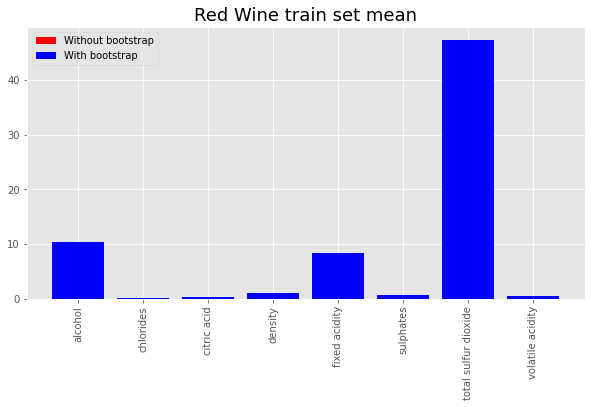

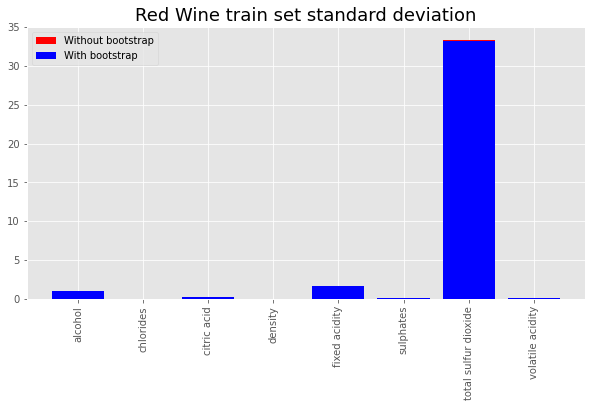

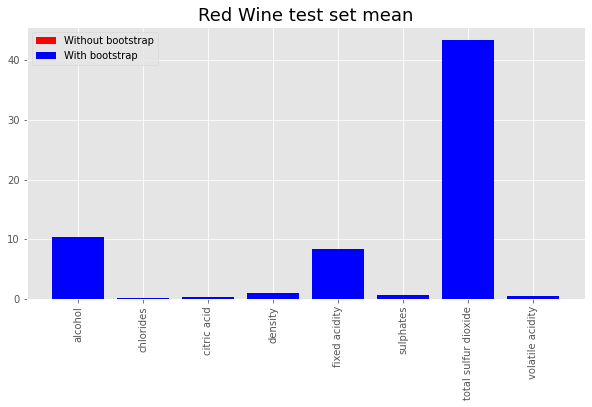

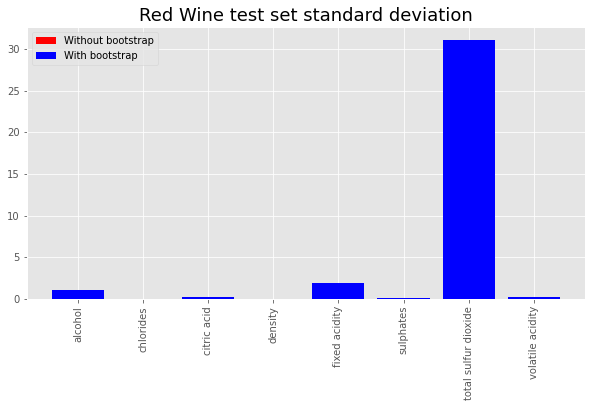

In [25]:
plot_df_means(X_train_r.mean(), est_mean_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set mean')
plot_df_means(X_train_r.std(), est_dev_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set standard deviation')
plot_df_means(X_test_r.mean(), est_mean_test_r, 'Without bootstrap','With bootstrap', 'Red Wine test set mean')
plot_df_means(X_test_r.std(), est_dev_test_r, 'Without bootstrap','With bootstrap', 'Red Wine test set standard deviation')

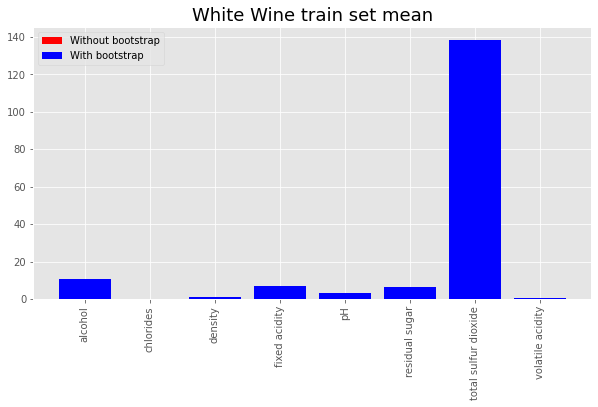

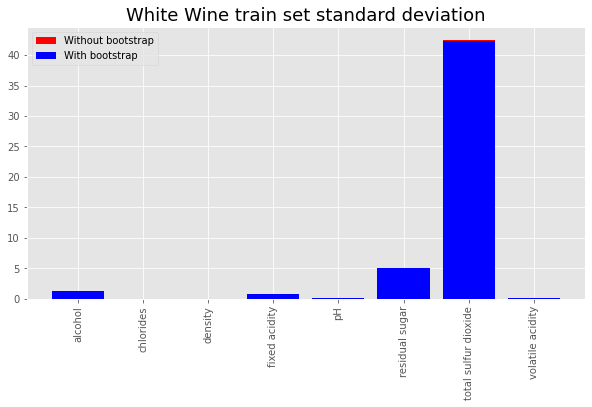

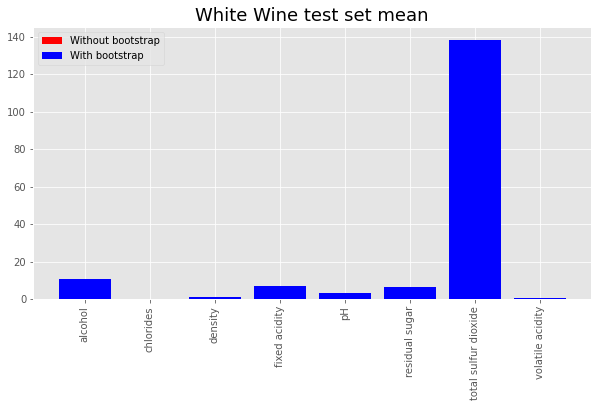

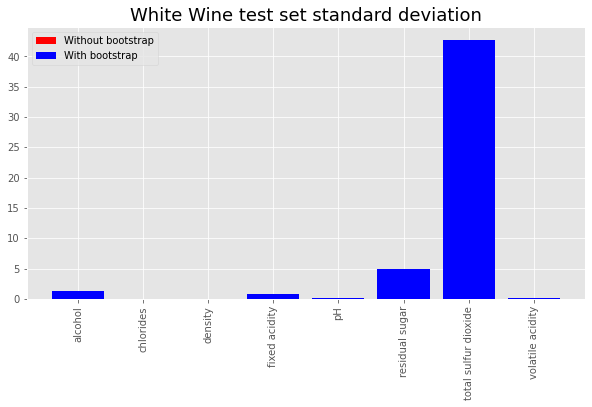

In [26]:
plot_df_means(X_train_w.mean(), est_mean_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set mean')
plot_df_means(X_train_w.std(), est_dev_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set standard deviation')
plot_df_means(X_test_w.mean(), est_mean_test_w, 'Without bootstrap','With bootstrap', 'White Wine test set mean')
plot_df_means(X_test_w.std(), est_dev_test_w, 'Without bootstrap','With bootstrap', 'White Wine test set standard deviation')

In [27]:
#Data standardization
X_train_r_std = (X_train_r - est_mean_train_r) / est_dev_train_r
X_test_r_std = (X_test_r - est_mean_test_r) / est_dev_test_r

X_train_w_std = (X_train_w - est_mean_train_w) / est_dev_train_w
X_test_w_std = (X_test_w - est_mean_test_w) / est_dev_test_w

### Principal Component Analysis (PCA)

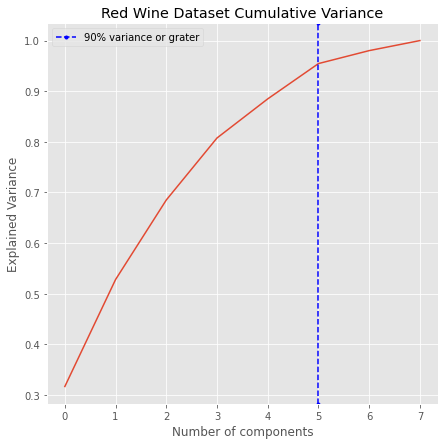

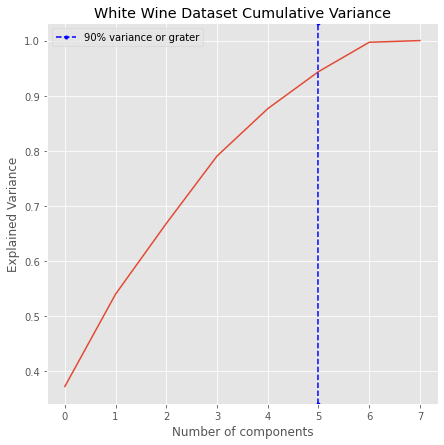

In [28]:
pca_r = PCA()
pca_w = PCA()
X_train_r_std_copy = copy.deepcopy(X_train_r_std)
X_test_r_std_copy = copy.deepcopy(X_test_r_std)
X_train_w_std_copy = copy.deepcopy(X_train_w_std)
X_test_w_std_copy = copy.deepcopy(X_test_w_std)

X_train_r_pca = pca_r.fit_transform(X_train_r_std_copy)
X_test_r_pca = pca_r.transform(X_test_r_std_copy)

X_train_w_pca = pca_w.fit_transform(X_train_w_std_copy)
X_test_w_pca = pca_w.transform(X_test_w_std_copy)

n_PC_90th_r = plot_explained_variance(pca_r.explained_variance_ratio_, 'Red Wine Dataset Cumulative Variance')
n_PC_90th_w = plot_explained_variance(pca_w.explained_variance_ratio_, 'White Wine Dataset Cumulative Variance')

In [29]:
n_PC_90th_r = int(n_PC_90th_r)
n_PC_90th_w = int(n_PC_90th_w)

X_train_r_reduced = pd.DataFrame(X_train_r_pca[:,:n_PC_90th_r], columns=[f'PC{i}' for i in range(n_PC_90th_r)], index = X_train_r_std.index)
X_train_w_reduced = pd.DataFrame(X_train_w_pca[:,:n_PC_90th_w], columns=[f'PC{i}' for i in range(n_PC_90th_w)], index = X_train_w_std.index)

X_test_r_reduced = pd.DataFrame(X_test_r_pca[:,:n_PC_90th_r], columns=[f'PC{i}' for i in range(n_PC_90th_r)], index = X_test_r_std.index)
X_test_w_reduced = pd.DataFrame(X_test_w_pca[:,:n_PC_90th_w], columns=[f'PC{i}' for i in range(n_PC_90th_w)], index = X_test_w_std.index)

### Output conversion

In [30]:
# Recreate datasets
y_train_r_bin = copy.deepcopy(y_train_r)

y_test_r_bin = y_test_r.copy()
y_train_w_bin = y_train_w.copy()
y_test_w_bin = y_test_w.copy()

# 'quality' becomes a binary label: 0 = bad; 1 = good
y_train_r_bin = np.where(y_train_r_bin > 5, 1, 0)
y_test_r_bin = np.where(y_test_r_bin > 5, 1, 0)

y_train_w_bin = np.where(y_train_w_bin > 5, 1, 0)
y_test_w_bin = np.where(y_test_w_bin > 5, 1, 0)

### Dataset Oversampling: ADASYN Algorithm (Adaptive Synthetic Sampling Method for Imbalanced Data)
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.

In [31]:
sampler = ADASYN(sampling_strategy='minority', random_state=0)

print("###### White Wine dataset ######")
print(Counter(y_train_w_bin))
X_ADASYN_w, y_ADASYN_w = sampler.fit_resample(X_train_w_reduced, y_train_w_bin)
print(Counter(y_ADASYN_w))

###### White Wine dataset ######
Counter({1: 2606, 0: 1312})
Counter({1: 2606, 0: 2445})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Classification

Proposed algorithms:
1. Logistic Regression
2. SVM

The classification algorithms will be trained on both oversampled and not oversampled sets and the obtained results will be compared.

In [32]:
def classification(X_train, y_train, X_test, y_test, clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

In [33]:
def print_classification_report(X_train, y_train, X_test, y_test, clf):
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

### Logistic Regression

In [34]:
LR_acc= np.zeros((1,3))
LR_f1= np.zeros((1,3))

#### PCA-reduced dataset

######### Red Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.6s finished


{'C': 0.01}
accuracy Red Wine:
0.715625
F1 score Red Wine:
0.6996699669966997
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       149
           1       0.74      0.72      0.73       171

    accuracy                           0.72       320
   macro avg       0.71      0.72      0.71       320
weighted avg       0.72      0.72      0.72       320



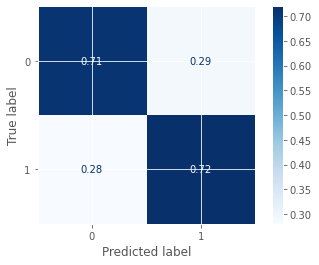

In [35]:
# Parameters Tuning
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


print("######### Red Wine dataset #########")
clf_r = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_r = GridSearchCV(clf_r, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_r.fit(X_train_r_reduced, y_train_r_bin).score(X_test_r_reduced, y_test_r_bin)
y_pred = clf_r.predict(X_test_r_reduced)
LR_acc[0,0] = acc
F1 = f1_score(y_test_r_bin, y_pred, average=None)
LR_f1[0,0] = F1[0]

print(clf_r.best_params_)
print("accuracy Red Wine:")
print(acc)
print("F1 score Red Wine:")
print(F1[0])
print_classification_report(X_train_r_reduced, y_train_r_bin, X_test_r_reduced, y_test_r_bin, clf_r)

######### White Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.4s finished


{'C': 10}
accuracy White Wine:
0.710204081632653
F1 score White Wine:
0.4342629482071713
              precision    recall  f1-score   support

           0       0.63      0.33      0.43       328
           1       0.73      0.90      0.81       652

    accuracy                           0.71       980
   macro avg       0.68      0.62      0.62       980
weighted avg       0.69      0.71      0.68       980



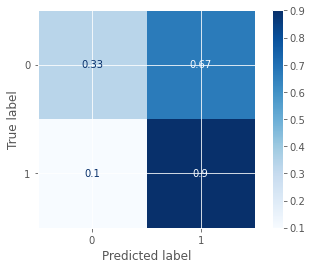

In [36]:
print("######### White Wine dataset #########")
clf_w = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_train_w_reduced, y_train_w_bin).score(X_test_w_reduced, y_test_w_bin)
y_pred = clf_w.predict(X_test_w_reduced)
LR_acc[0,1] = acc
F1 = f1_score(y_test_w_bin, y_pred, average=None)
LR_f1[0,1] = F1[0]

print(clf_w.best_params_)
print("accuracy White Wine:")
print(acc)
print("F1 score White Wine:")
print(F1[0])
print_classification_report(X_train_w_reduced, y_train_w_bin, X_test_w_reduced, y_test_w_bin, clf_w)

#### PCA-reduced dataset and oversampled train set 

######### White Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished


{'C': 10}
accuracy White Wine adasyn:
0.7081632653061225
F1 score White Wine adasyn:
0.608219178082192
              precision    recall  f1-score   support

           0       0.55      0.68      0.61       328
           1       0.82      0.72      0.77       652

    accuracy                           0.71       980
   macro avg       0.68      0.70      0.69       980
weighted avg       0.73      0.71      0.71       980



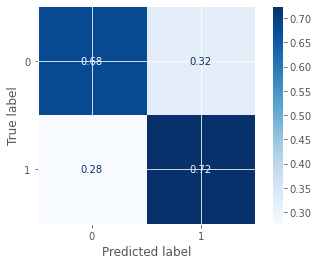

In [37]:
print("######### White Wine dataset #########")
clf_w = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_ADASYN_w, y_ADASYN_w).score(X_test_w_reduced, y_test_w_bin)
y_pred = clf_w.predict(X_test_w_reduced)
LR_acc[0,2] = acc
F1 = f1_score(y_test_w_bin, y_pred, average=None)
LR_f1[0,2] = F1[0]

print(clf_w.best_params_)
print("accuracy White Wine adasyn:")
print(acc)
print("F1 score White Wine adasyn:")
print(F1[0])
print_classification_report(X_ADASYN_w, y_ADASYN_w, X_test_w_reduced, y_test_w_bin, clf_w)

In [38]:
LR_acc_scores = pd.DataFrame(np.round(LR_acc, decimals = 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['Logistic Regression'])
LR_acc_scores 

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.72,0.71,0.71


In [39]:
LR_f1_scores = pd.DataFrame(np.round(LR_f1, decimals = 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['Logistic Regression'])
LR_f1_scores 

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.7,0.43,0.61


### Support Vector Machines

#### PCA-reduced dataset

In [40]:
SVM_acc_linear = np.zeros((1,3))
SVM_f1_linear = np.zeros((1,3))

SVM_acc_rbf = np.zeros((1,3))
SVM_f1_rbf = np.zeros((1,3))

params_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
params_grid_rbf    = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10**(-7), 10**(-5), 10**(-3), 10**(-1), 0.5, 1, 10, 100]}

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   19.3s finished


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   15.5s finished


######### Linear kernel param (Red Wine) #########
{'C': 1000}
accuracy: 
0.709375
F1 score: 
0.7028753993610224
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       149
           1       0.75      0.68      0.72       171

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.71      0.71       320

######### RBF kernel param (Red Wine) #########
{'C': 1, 'gamma': 0.5}
accuracy: 
0.709375
F1 score: 
0.6868686868686869
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       149
           1       0.73      0.73      0.73       171

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.71      0.71       320



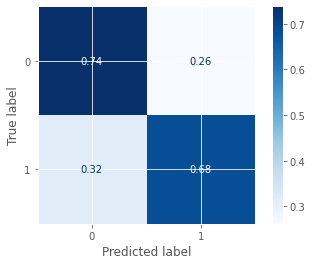

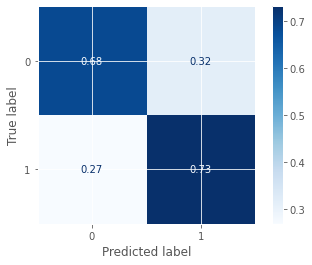

In [41]:
## Linear Kernel
clf_r_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_r_linear = GridSearchCV(clf_r_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_r_linear.fit(X_train_r_reduced, y_train_r_bin).score(X_test_r_reduced, y_test_r_bin)
y_pred_linear = clf_r_linear.predict(X_test_r_reduced)

SVM_acc_linear[0,0] = acc_linear
F1_linear = f1_score(y_test_r_bin, y_pred_linear, average=None)
SVM_f1_linear[0,0] = F1_linear[0]

## RBF kernel
clf_r_rbf = SVC(kernel = 'rbf')
clf_r_rbf = GridSearchCV(clf_r_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_r_rbf.fit(X_train_r_reduced, y_train_r_bin).score(X_test_r_reduced, y_test_r_bin)
y_pred_rbf = clf_r_rbf.predict(X_test_r_reduced)

SVM_acc_rbf[0,0] = acc_rbf
F1_rbf = f1_score(y_test_r_bin, y_pred_rbf, average=None)
SVM_f1_rbf[0,0] = F1_rbf[0]

print("######### Linear kernel param (Red Wine) #########")
print(clf_r_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print('F1 score: ')
print(F1_linear[0])
print_classification_report(X_train_r_reduced, y_train_r_bin, X_test_r_reduced, y_test_r_bin, clf_r_linear)



print("######### RBF kernel param (Red Wine) #########")
print(clf_r_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print('F1 score: ')
print(F1_rbf[0])
print_classification_report(X_train_r_reduced, y_train_r_bin, X_test_r_reduced, y_test_r_bin, clf_r_rbf)

           PC0       PC1       PC2       PC3       PC4
963   0.789791  1.598222  0.687075 -0.220920 -0.613304
475   0.419688 -0.866669 -0.672179 -0.884823  0.521786
1    -0.994711 -1.961034  0.943083 -0.251163  1.008379
329   1.123016  0.017167 -1.526582 -0.492658 -0.480130
149   0.774151  0.385723 -0.081761  0.231595 -0.451475
...        ...       ...       ...       ...       ...
1173  0.317987 -0.311985  0.012854  1.003774 -1.047023
827  -1.172892  0.235077 -0.462276  0.053264 -0.583705
356   2.974814  0.565960 -0.012660  0.264351  1.027226
1287 -2.875306  2.142315 -1.204176 -0.717699  0.810786
789   0.034524 -2.247957  0.118400  1.712179  0.225765

[320 rows x 5 columns]
n_features:  5
           PC0       PC1       PC2       PC3       PC4
963   0.789791  1.598222  0.687075 -0.220920 -0.613304
475   0.419688 -0.866669 -0.672179 -0.884823  0.521786
1    -0.994711 -1.961034  0.943083 -0.251163  1.008379
329   1.123016  0.017167 -1.526582 -0.492658 -0.480130
149   0.774151  0.385723 -

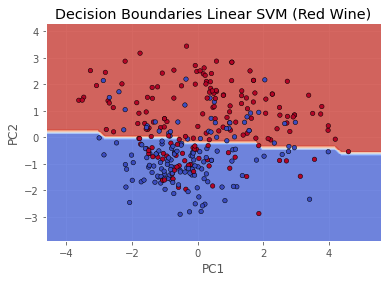

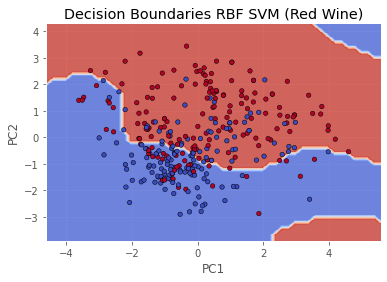

In [42]:
decision_boundaries(X_test_r_reduced, y_test_r_bin, 'Decision Boundaries Linear SVM (Red Wine)', clf_r_linear)
decision_boundaries(X_test_r_reduced, y_test_r_bin, 'Decision Boundaries RBF SVM (Red Wine)', clf_r_rbf)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.2min finished


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  2.6min finished


######### Linear kernel param (White Wine) #########
{'C': 0.1}
accuracy: 
0.6785714285714286
F1 score: 
0.2105263157894737
              precision    recall  f1-score   support

           0       0.59      0.13      0.21       328
           1       0.69      0.96      0.80       652

    accuracy                           0.68       980
   macro avg       0.64      0.54      0.50       980
weighted avg       0.65      0.68      0.60       980

######### RBF kernel param (White Wine) #########
{'C': 1, 'gamma': 1}
accuracy: 
0.7244897959183674
F1 score: 
0.5246478873239436
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       328
           1       0.76      0.86      0.81       652

    accuracy                           0.72       980
   macro avg       0.69      0.66      0.67       980
weighted avg       0.71      0.72      0.71       980



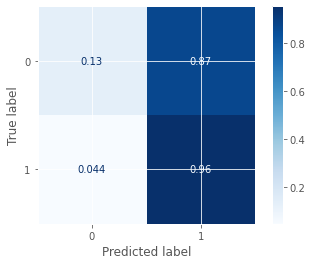

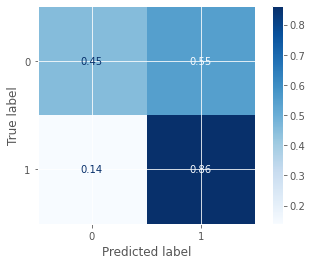

In [43]:
## Linear Kernel
clf_w_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_w_linear = GridSearchCV(clf_w_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_w_linear.fit(X_train_w_reduced, y_train_w_bin).score(X_test_w_reduced, y_test_w_bin)
y_pred_linear = clf_w_linear.predict(X_test_w_reduced)

SVM_acc_linear[0,1] = acc_linear
F1_linear = f1_score(y_test_w_bin, y_pred_linear, average=None)
SVM_f1_linear[0,1] = F1_linear[0]

## RBF kernel
clf_w_rbf = SVC(kernel = 'rbf')
clf_w_rbf = GridSearchCV(clf_w_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_w_rbf.fit(X_train_w_reduced, y_train_w_bin).score(X_test_w_reduced, y_test_w_bin)
y_pred_rbf = clf_w_rbf.predict(X_test_w_reduced)

SVM_acc_rbf[0,1] = acc_rbf
F1_rbf = f1_score(y_test_w_bin, y_pred_rbf, average=None)
SVM_f1_rbf[0,1] = F1_rbf[0]

print("######### Linear kernel param (White Wine) #########")
print(clf_w_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print('F1 score: ')
print(F1_linear[0])
print_classification_report(X_train_w_reduced, y_train_w_bin, X_test_w_reduced, y_test_w_bin, clf_w_linear)


print("######### RBF kernel param (White Wine) #########")
print(clf_w_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print('F1 score: ')
print(F1_rbf[0])
print_classification_report(X_train_w_reduced, y_train_w_bin, X_test_w_reduced, y_test_w_bin, clf_w_rbf)

           PC0       PC1       PC2       PC3       PC4
1740  0.932138 -0.272017  0.874842  0.439557 -0.244812
2658  1.279516 -0.869860 -1.283667 -0.238397 -0.404247
1203 -1.989015 -2.664487  0.370210  0.318020 -0.554724
3985  0.160400  0.032999 -1.739913  0.212794 -0.746906
2945 -3.826870 -1.660436  0.758161 -1.142380  0.198777
...        ...       ...       ...       ...       ...
4393  1.467524 -0.824741 -1.102009 -0.855172 -1.135896
1454  4.589466  1.270671 -0.760360 -0.812224  0.353424
2576  1.806665 -0.825071 -0.196581 -0.581780  0.712600
4501  2.227974 -1.538250  2.174152 -1.435095 -0.081740
3638 -2.741153  0.101782  0.005801 -0.943413 -0.220552

[980 rows x 5 columns]
n_features:  5
           PC0       PC1       PC2       PC3       PC4
1740  0.932138 -0.272017  0.874842  0.439557 -0.244812
2658  1.279516 -0.869860 -1.283667 -0.238397 -0.404247
1203 -1.989015 -2.664487  0.370210  0.318020 -0.554724
3985  0.160400  0.032999 -1.739913  0.212794 -0.746906
2945 -3.826870 -1.660436  

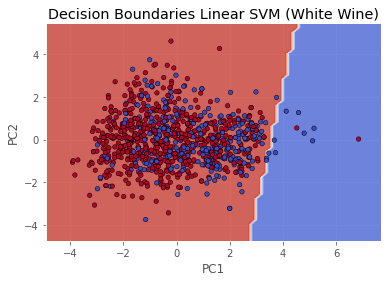

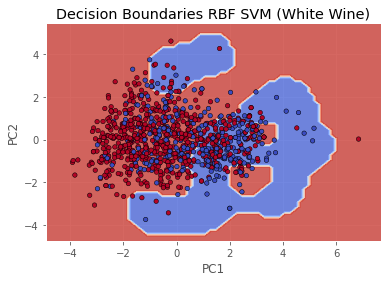

In [44]:
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries Linear SVM (White Wine)', clf_w_linear)
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries RBF SVM (White Wine)', clf_w_rbf)

#### PCA-reduced dataset and oversampled train set

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.2min finished


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  4.7min finished


######### Linear kernel param (White Wine adasyn)#########
{'C': 1000}
accuracy: 
0.6877551020408164
F1 score: 
0.6046511627906976
              precision    recall  f1-score   support

           0       0.52      0.71      0.60       328
           1       0.82      0.67      0.74       652

    accuracy                           0.69       980
   macro avg       0.67      0.69      0.67       980
weighted avg       0.72      0.69      0.70       980

######### RBF kernel param (White Wine adasyn)#########
{'C': 10, 'gamma': 10}
accuracy: 
0.7704081632653061
F1 score: 
0.5794392523364487
              precision    recall  f1-score   support

           0       0.75      0.47      0.58       328
           1       0.78      0.92      0.84       652

    accuracy                           0.77       980
   macro avg       0.76      0.70      0.71       980
weighted avg       0.77      0.77      0.75       980



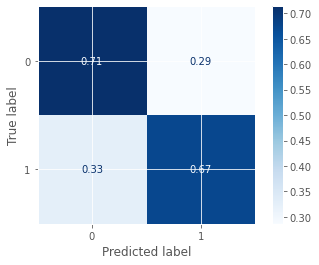

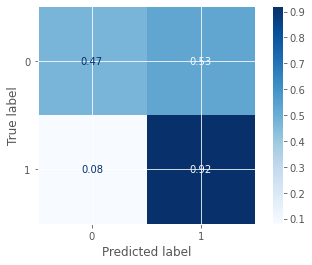

In [45]:
## Linear Kernel
clf_w_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_w_linear = GridSearchCV(clf_w_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_w_linear.fit(X_ADASYN_w, y_ADASYN_w).score(X_test_w_reduced, y_test_w_bin)
y_pred_linear = clf_w_linear.predict(X_test_w_reduced)

SVM_acc_linear[0,2] = acc_linear
F1_linear = f1_score(y_test_w_bin, y_pred_linear, average=None)
SVM_f1_linear[0,2] = F1_linear[0]


# RBF Kernel
clf_w_rbf = SVC(kernel = 'rbf')
clf_w_rbf = GridSearchCV(clf_w_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_w_rbf.fit(X_ADASYN_w, y_ADASYN_w).score(X_test_w_reduced, y_test_w_bin)
y_pred_rbf = clf_w_rbf.predict(X_test_w_reduced)

SVM_acc_rbf[0,2] = acc_rbf 
F1_rbf = f1_score(y_test_w_bin, y_pred_rbf, average=None)
SVM_f1_rbf[0,2] = F1_rbf[0]

print("######### Linear kernel param (White Wine adasyn)#########")
print(clf_w_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print('F1 score: ')
print(F1_linear[0])
print_classification_report(X_ADASYN_w, y_ADASYN_w, X_test_w_reduced, y_test_w_bin, clf_w_linear)

print("######### RBF kernel param (White Wine adasyn)#########")
print(clf_w_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print('F1 score: ')
print(F1_rbf[0])
print_classification_report(X_ADASYN_w, y_ADASYN_w, X_test_w_reduced, y_test_w_bin, clf_w_rbf)

           PC0       PC1       PC2       PC3       PC4
1740  0.932138 -0.272017  0.874842  0.439557 -0.244812
2658  1.279516 -0.869860 -1.283667 -0.238397 -0.404247
1203 -1.989015 -2.664487  0.370210  0.318020 -0.554724
3985  0.160400  0.032999 -1.739913  0.212794 -0.746906
2945 -3.826870 -1.660436  0.758161 -1.142380  0.198777
...        ...       ...       ...       ...       ...
4393  1.467524 -0.824741 -1.102009 -0.855172 -1.135896
1454  4.589466  1.270671 -0.760360 -0.812224  0.353424
2576  1.806665 -0.825071 -0.196581 -0.581780  0.712600
4501  2.227974 -1.538250  2.174152 -1.435095 -0.081740
3638 -2.741153  0.101782  0.005801 -0.943413 -0.220552

[980 rows x 5 columns]
n_features:  5
           PC0       PC1       PC2       PC3       PC4
1740  0.932138 -0.272017  0.874842  0.439557 -0.244812
2658  1.279516 -0.869860 -1.283667 -0.238397 -0.404247
1203 -1.989015 -2.664487  0.370210  0.318020 -0.554724
3985  0.160400  0.032999 -1.739913  0.212794 -0.746906
2945 -3.826870 -1.660436  

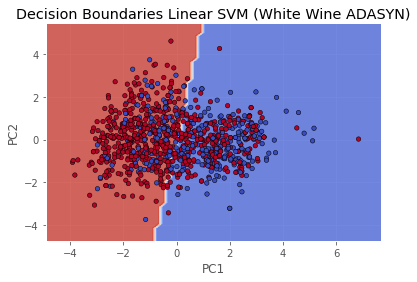

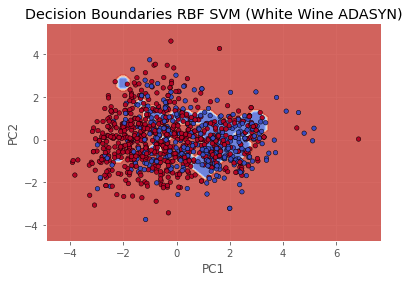

In [46]:
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries Linear SVM (White Wine ADASYN)', clf_w_linear)
decision_boundaries(X_test_w_reduced, y_test_w_bin, 'Decision Boundaries RBF SVM (White Wine ADASYN)', clf_w_rbf)

In [47]:
SVM_acc_scores_linear = pd.DataFrame(np.round(SVM_acc_linear, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM linear'])
SVM_acc_scores_linear

,Red Wine,White Wine,White wine adasyn
SVM linear,0.71,0.68,0.69


In [48]:
SVM_acc_scores_rbf = pd.DataFrame(np.round(SVM_acc_rbf, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM rbf'])
SVM_acc_scores_rbf

,Red Wine,White Wine,White wine adasyn
SVM rbf,0.71,0.72,0.77


In [49]:
SVM_f1_scores_linear = pd.DataFrame(np.round(SVM_f1_linear, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM linear'])
SVM_f1_scores_linear

,Red Wine,White Wine,White wine adasyn
SVM linear,0.7,0.21,0.6


In [50]:
SVM_f1_scores_rbf = pd.DataFrame(np.round(SVM_f1_rbf, 2), columns=['Red Wine', 'White Wine','White wine adasyn'], index=['SVM rbf'])
SVM_f1_scores_rbf

,Red Wine,White Wine,White wine adasyn
SVM rbf,0.69,0.52,0.58


### Classification Results 

In [51]:
classification_acc_results = LR_acc_scores.append(SVM_acc_scores_linear).append(SVM_acc_scores_rbf)
classification_acc_results

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.72,0.71,0.71
SVM linear,0.71,0.68,0.69
SVM rbf,0.71,0.72,0.77


In [52]:
classification_f1_results = LR_f1_scores.append(SVM_f1_scores_linear).append(SVM_f1_scores_rbf)
classification_f1_results

,Red Wine,White Wine,White wine adasyn
Logistic Regression,0.70,0.43,0.61
SVM linear,0.70,0.21,0.60
SVM rbf,0.69,0.52,0.58


##Regression

Proposed algorithms:
1. Linear Regression
2. Polinomial Regression
3. Ridge Regression
4. Lasso Regression

The regression algorithms will be trained on both PCA applied and PCA not applied sets (without oversampling) and the obtained results will be compared.

In [53]:
def plot_mean_squared_error_per_class(y, y_pred, fig_size=(18,1), title = 'title'):
  res = []
  res_f = []
  y = list(y)
  labels = list(set(y))

  for label in labels:
    ind = [i for i, j in enumerate(y) if j == label]
    y_l = [y[i] for i in range(len(y)) if i in ind]
    y_l_pred = [y_pred[i] for i in range(len(y_pred)) if i in ind]
    res_l = mean_squared_error(y_l, y_l_pred)
    res.append(res_l*-1)

  res_f.append(res)
  fig, ax = plt.subplots(figsize=fig_size)
  rdd = pd.DataFrame(res_f, index = ['MSE'], columns = labels)
  sns.heatmap(rdd, annot=True, cmap='BuGn')
  plt.xlabel('Qualities')
  plt.title(title,fontsize=14)
  plt.show()
  return

def plot_prediction_error_per_class_bar(y, y_pred, fig_size=(7,7), title = 'title'):
  res = []
  res_f = []
  y = list(y)
  
  labels = list(set(y))

  for label in labels:
    ind = [i for i, j in enumerate(y) if j == label]
    y_l = [y[i] for i in range(len(y)) if i in ind]
    y_l_pred = [y_pred[i] for i in range(len(y_pred)) if i in ind]
    y_l_pred_mean = np.mean(y_l_pred)
    y_l_delta = y_l_pred_mean - y_l[0]
    res.append(y_l_delta)

  
  fig, ax = plt.subplots(figsize=fig_size)
  ax.bar([x for x in labels], res)
  plt.xlabel('Qualities')
  plt.title(title,fontsize=14)
  plt.show()
  return

In [54]:
#for Red dataset, wines with quality = 3 and 8 are considered outlier. Same as with wines with quality = 3, 8 and 9 in White wine (see Boxplot)
#---> we remove instances with these quantities
idx_r = list(y_train_r.index)
indexes_r = [i for i in idx_r if i not in quality_r_out] #index_r rappresenta tutti gli indici che sono nel training set e che non inclusi in quelli da rimuovere. 
                                                         #Sono quindi gli indici 'buoni'

X_train_r_std = X_train_r_std.loc[indexes_r]
X_train_r_reduced = X_train_r_reduced.loc[indexes_r]
y_train_r = y_train_r.loc[indexes_r]


idx_w = list(y_train_w.index)
indexes_w = [i for i in idx_w if i not in quality_w_out]

X_train_w_std = X_train_w_std.loc[indexes_w]
X_train_w_reduced = X_train_w_reduced.loc[indexes_w]
y_train_w = y_train_w.loc[indexes_w]

### Linear Regression

In [55]:
lr_mse = np.zeros((1,4))

#### PCA dataset

Overall mean squared error Red wines (PCA): 0.42


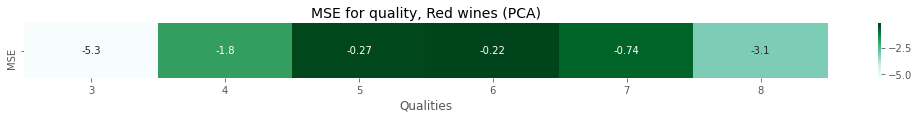

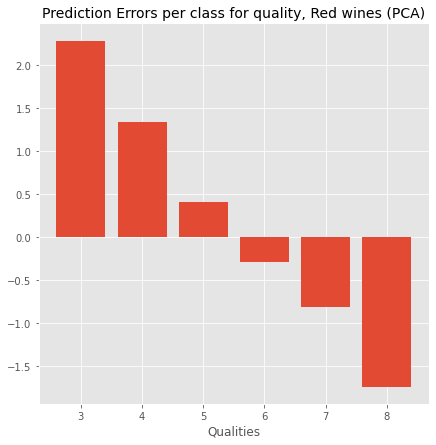

In [56]:
reg = LinearRegression()
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 
MSE = mean_squared_error(y_test_r, y_pred)

lr_mse[0,0] = MSE

print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')

Overall mean squared error White wines (PCA): 0.68


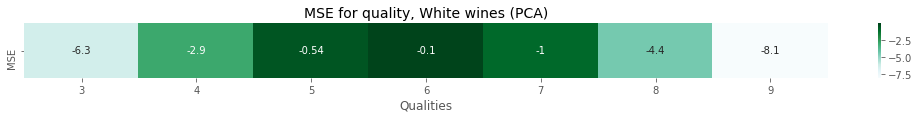

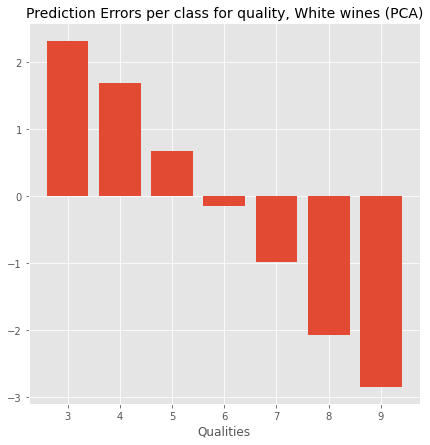

In [57]:
reg = LinearRegression()
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 
MSE = mean_squared_error(y_test_w, y_pred)

lr_mse[0,2] = MSE

print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')

#### No PCA dataset

Overall mean squared error Red wines (no PCA): 0.40


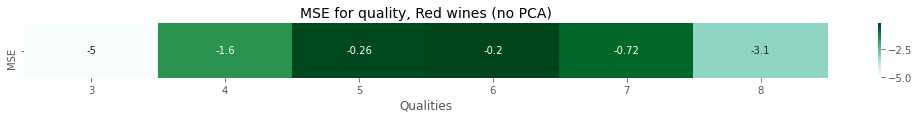

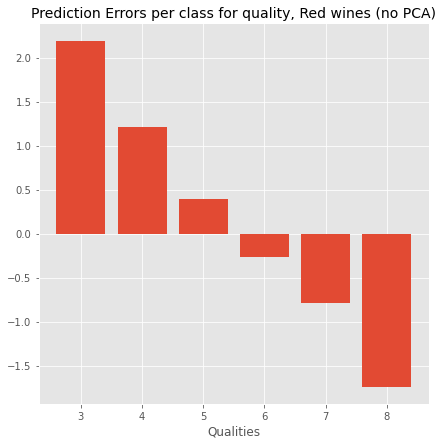

In [58]:
reg = LinearRegression()
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 
MSE = mean_squared_error(y_test_r, y_pred)

lr_mse[0,1] = MSE

print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')

Overall mean squared error White wines (no PCA): 0.59


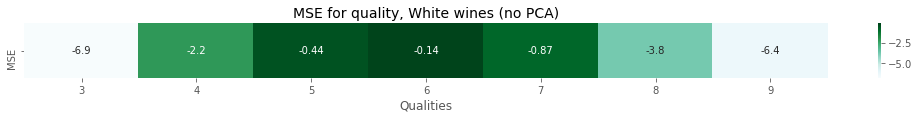

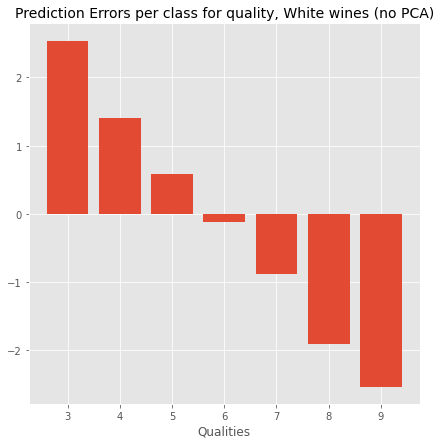

In [59]:
reg = LinearRegression()
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 
MSE = mean_squared_error(y_test_w, y_pred)

lr_mse[0,3] = MSE

print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')

In [60]:
lr__mse_scores = pd.DataFrame(lr_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Linear Regression'])
lr__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Linear Regression,0.419079,0.397611,0.677608,0.593801


### Polinomial Regression

In [61]:
pr_mse = np.zeros((1,4))

#### PCA dataset

Overall mean squared error Red wines (PCA): 0.42


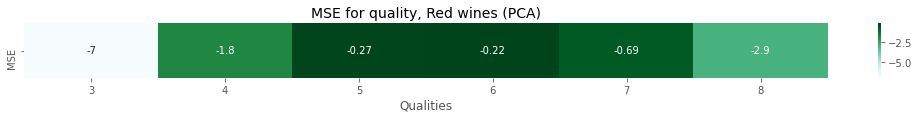

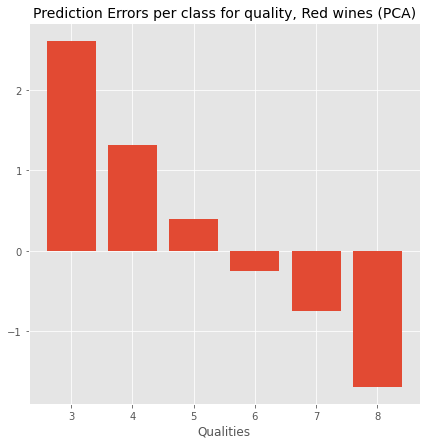

In [62]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 

MSE = mean_squared_error(y_test_r, y_pred)
pr_mse[0,0] = MSE

print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')

Overall mean squared error White wines (PCA): 0.61


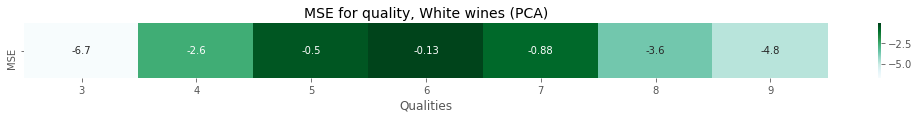

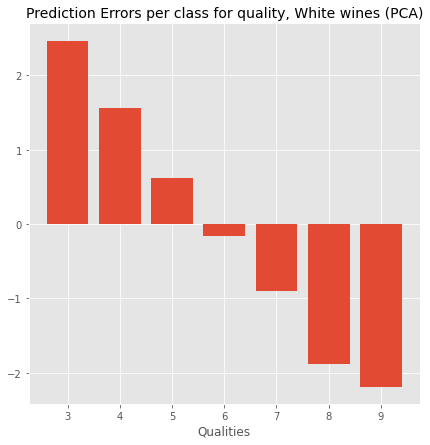

In [63]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 

MSE = mean_squared_error(y_test_w, y_pred)
pr_mse[0,2] = MSE

print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')

#### No PCA dataset

Overall mean squared error Red wines (no PCA): 0.40


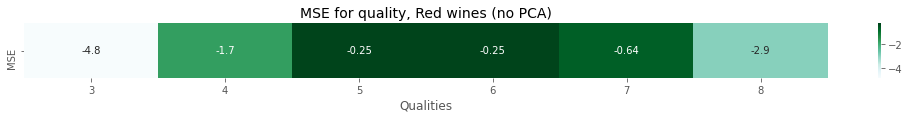

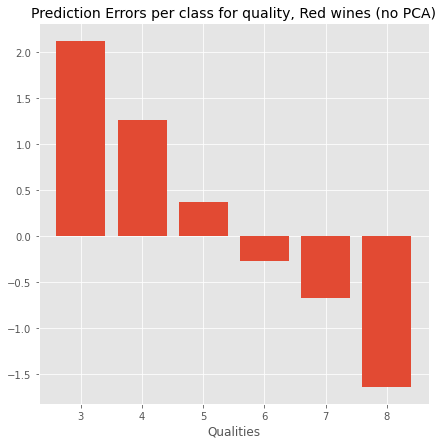

In [64]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 

MSE = mean_squared_error(y_test_r, y_pred)
pr_mse[0,1] = MSE

print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')

Overall mean squared error White wines (no PCA): 0.57


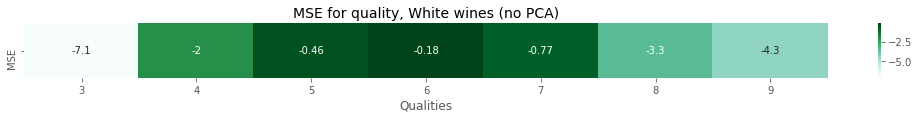

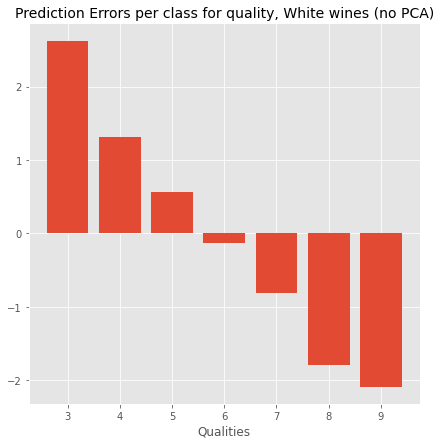

In [65]:
reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 

MSE = mean_squared_error(y_test_w, y_pred)
pr_mse[0,3] = MSE

print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')

In [66]:
pr__mse_scores = pd.DataFrame(pr_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Polinomial Regression'])
pr__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Polinomial Regression,0.42356,0.403661,0.614096,0.574102


### Ridge Regression

In [67]:
rr_mse = np.zeros((1,4))

parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100,1000]}
scoring = 'neg_mean_squared_error'

#### PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 10}
Overall mean squared error Red wines (PCA): 0.42


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


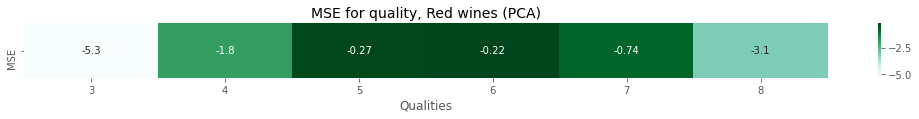

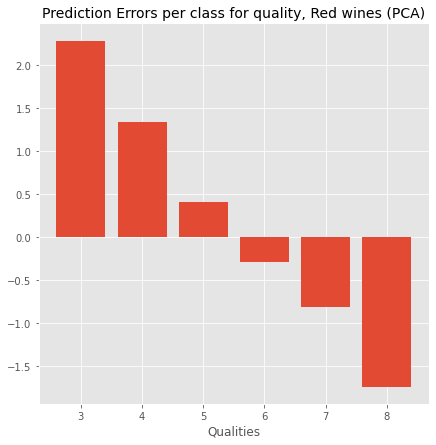

In [68]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 
MSE = mean_squared_error(y_test_r, y_pred)

rr_mse[0,0] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 100}
Overall mean squared error White wines (PCA): 0.68


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


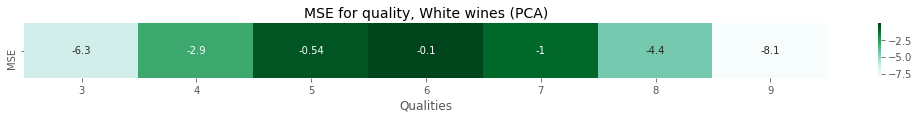

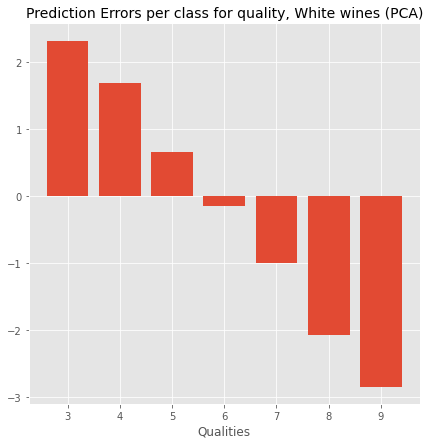

In [69]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 
MSE = mean_squared_error(y_test_w, y_pred)

rr_mse[0,2] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')


#### No PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 10}
Overall mean squared error Red wines (no PCA): 0.40


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


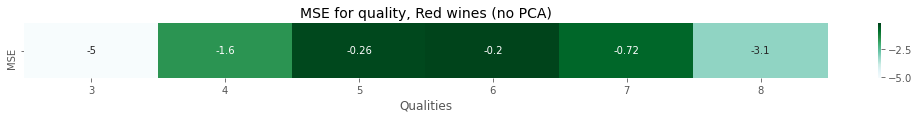

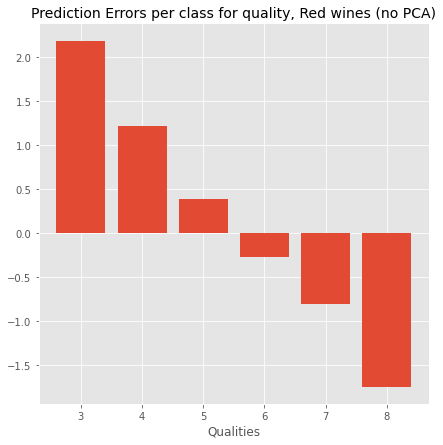

In [70]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 
MSE = mean_squared_error(y_test_r, y_pred)

rr_mse[0,1] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 100}
Overall mean squared error White wines (no PCA): 0.60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


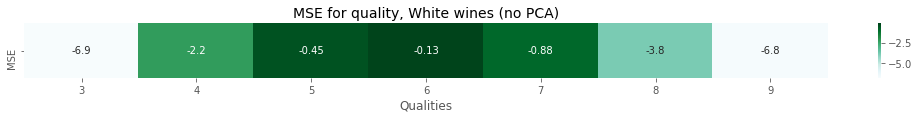

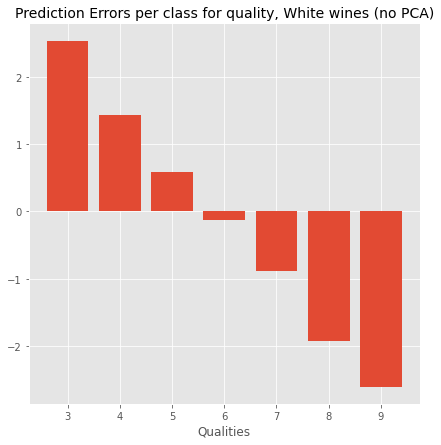

In [71]:
reg = Ridge()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 
MSE = mean_squared_error(y_test_w, y_pred)

rr_mse[0,3] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')


In [72]:
rr__mse_scores = pd.DataFrame(rr_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Ridge Regression'])
rr__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Ridge Regression,0.419282,0.397965,0.677539,0.596583


### Lasso Regression

In [73]:
lasso_r_mse = np.zeros((1,4))

parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100,1000]}
scoring = 'neg_mean_squared_error'

#### PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.001}
Overall mean squared error Red wines (PCA): 0.42


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


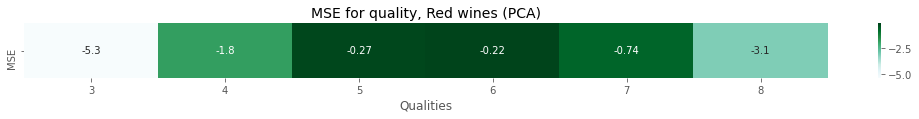

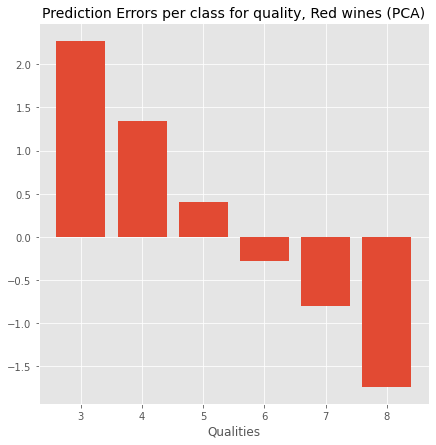

In [74]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_reduced, y_train_r)
y_pred = reg.predict(X_test_r_reduced) 
MSE = mean_squared_error(y_test_r, y_pred)

lasso_r_mse[0,0] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.01}
Overall mean squared error White wines (PCA): 0.68


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


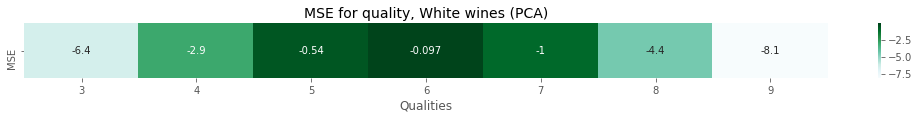

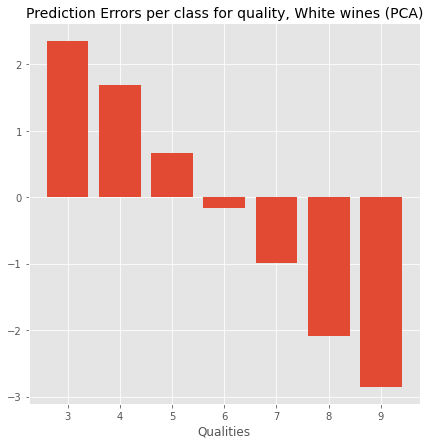

In [75]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_reduced, y_train_w)
y_pred = reg.predict(X_test_w_reduced) 
MSE = mean_squared_error(y_test_w, y_pred)

lasso_r_mse[0,2] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (PCA)')


#### No PCA dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.001}
Overall mean squared error Red wines (no PCA): 0.40


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


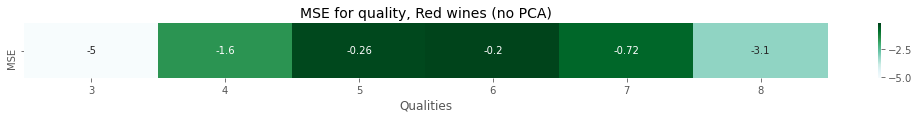

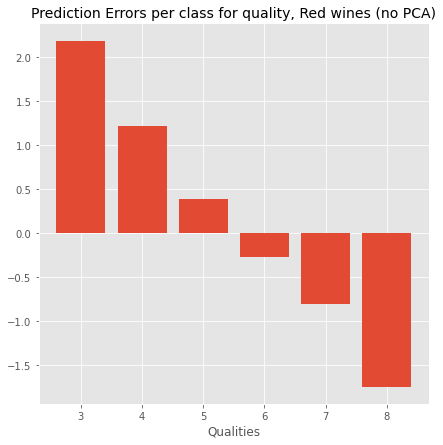

In [76]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_r_std, y_train_r)
y_pred = reg.predict(X_test_r_std) 
MSE = mean_squared_error(y_test_r, y_pred)

lasso_r_mse[0,1] = MSE

print(reg.best_params_)
print(f'Overall mean squared error Red wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_r, y_pred, title='MSE for quality, Red wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_r, y_pred, title='Prediction Errors per class for quality, Red wines (no PCA)')


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished


{'alpha': 0.001}
Overall mean squared error White wines (no PCA): 0.59


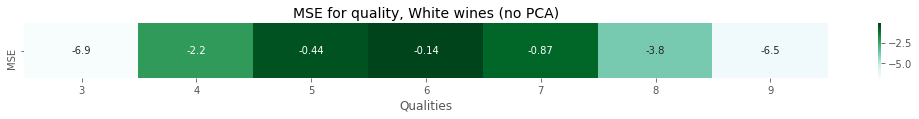

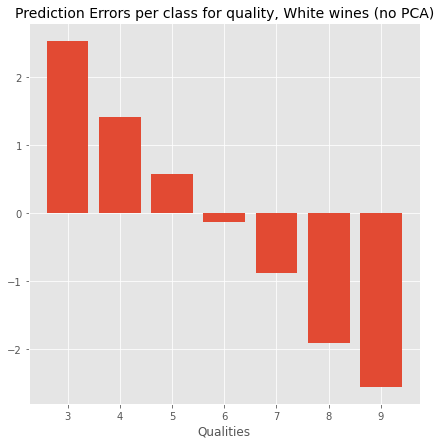

In [77]:
reg = Lasso()

reg = GridSearchCV(reg, param_grid=parameters, scoring=scoring, verbose=1, n_jobs=-1)
reg = reg.fit(X_train_w_std, y_train_w)
y_pred = reg.predict(X_test_w_std) 
MSE = mean_squared_error(y_test_w, y_pred)

lasso_r_mse[0,3] = MSE

print(reg.best_params_)
print(f'Overall mean squared error White wines (no PCA): {MSE:.2f}')
plot_mean_squared_error_per_class(y_test_w, y_pred, title='MSE for quality, White wines (no PCA)')
plot_prediction_error_per_class_bar(y_test_w, y_pred, title='Prediction Errors per class for quality, White wines (no PCA)')


In [78]:
lasso_r__mse_scores = pd.DataFrame(lasso_r_mse, columns=['Red_Wine_PCA', 'Red_Wine_No_PCA','White_Wine_PCA',  'White_Wine_No_PCA',], index=['Lasso Regression'])
lasso_r__mse_scores

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Lasso Regression,0.419195,0.39813,0.678578,0.594218


### Regression Results 

In [79]:
regression_mse_results = lr__mse_scores.append(pr__mse_scores).append(rr__mse_scores).append(lasso_r__mse_scores) 
regression_mse_results

,Red_Wine_PCA,Red_Wine_No_PCA,White_Wine_PCA,White_Wine_No_PCA
Linear Regression,0.419079,0.397611,0.677608,0.593801
Polinomial Regression,0.423560,0.403661,0.614096,0.574102
Ridge Regression,0.419282,0.397965,0.677539,0.596583
Lasso Regression,0.419195,0.398130,0.678578,0.594218
